## Plant Disease Detection

### Import Librarires

In [20]:
import matplotlib.pyplot as plt
import torch
import torchvision
import os

from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

### Setup

In [45]:
device = "cuda"
training_data_directory = "PlantVillage_Split/training"
validation_data_directory = "PlantVillage_Split/validation"
test_data_directory = "PlantVillage_Split/test"
seed_value = 27

class_names = [
 'Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

number_of_classes = len(class_names)
batch_size = 32
image_size = 224
patch_size = 16

embedding_dimension = 768

training_split = .7
validation_split = .2
test_split = .1

### Split Data into folders

In [28]:
import os
import shutil
import random
from tqdm import tqdm

clean_directory = "PlantVillage"
split_directory = "PlantVillage_Split"

# create sub sets
folders = ['training', 'validation', 'test']
for folder in folders:
    os.makedirs(os.path.join(split_directory, folder), exist_ok=True)

# loop over classes
for class_name in tqdm(class_names, desc="Split Classes"):
    path = os.path.join(clean_directory, class_name)
    images = os.listdir(path)
    random.shuffle(images)

    # determine number of images in the current class
    image_count = len(images)
    train_count = int(image_count * training_split)
    validation_count = int(image_count * validation_split)

    splits = {
        'training': images[:train_count],
        'validation': images[train_count:train_count + validation_count],
        'test': images[train_count + validation_count:]
    }

    # copy files to corresponding directory
    for split in splits:
        target_directory = os.path.join(split_directory, split, class_name)
        os.makedirs(target_directory, exist_ok=True)

        # copy file
        for image in splits[split]:
            source = os.path.join(path, image)
            destination = os.path.join(target_directory, image)
            shutil.copy(source, destination)



plit Classes: 100%|█████████████████████████████████████████████████████████████████| 38/38 [00:18<00:00,  2.06it/s]

### Dataset and DataLoader Creation

In [39]:
number_of_workers = os.cpu_count()

def create_dataloaders(training_directory: str, 
                       validation_directory: str,
                       test_directory: str, 
                       transform: transforms.Compose, 
                       batch_size: int, 
                       number_of_workers: int=number_of_workers):
    training_data = datasets.ImageFolder(train_data_directory, transform=transform)
    validation_data = datasets.ImageFolder(validation_data_directory, transform=transform)
    test_data = datasets.ImageFolder(test_data_directory, transform=transform)

    training_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=number_of_workers, pin_memory=True)
    validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=False, num_workers=number_of_workers, pin_memory=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=number_of_workers, pin_memory=True)

    return training_dataloader, validation_dataloader, test_dataloader


### Manual Transforms

In [40]:
manual_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

### Create Data Loaders

In [42]:
training_dataloader, validation_dataloader, test_dataloader = create_dataloaders(
    training_directory=training_data_directory,
    validation_directory=validation_data_directory,
    test_directory=test_data_directory,
    transform=manual_transforms,
    batch_size=batch_size)


training_dataloader, validation_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fc1daed5120>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc1daed6770>)

torch.Size([3, 224, 224]) tensor(15)


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

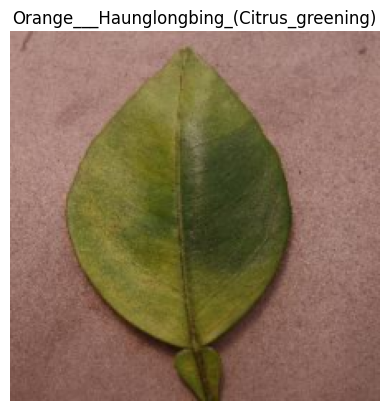

In [43]:
image_batch, label_batch = next(iter(training_dataloader))
image, label = image_batch[0], label_batch[0]

print(image.shape, label)

plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

### Patch Embedding

In [51]:
default_patch_size = 16
default_embedding_dimension = 768
default_in_channels = 3

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels:int=default_in_channels, patch_size:int=default_patch_size, embedding_dim:int=default_embedding_dimension):
        super().__init__()
        self.patcher = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size, padding=0)
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}"

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        return x_flattened.permute(0, 2, 1)

In [53]:
def set_seeds(seed:int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seeds()
patchify = PatchEmbedding(in_channels=3, patch_size=16, embedding_dim=768)

print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [56]:
set_seeds()

print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print(f"Input image with batch dimensions shape: {x.shape}")

patch_embedding_layer = PatchEmbedding(in_channels=3, patch_size=patch_size, embedding_dim=embedding_dimension)

patch_embedding = patch_embedding_layer(x)
print(f"Patch Embedding Shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension), requires_grad=True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and Position embedding shape: {patch_and_position_embedding.shape}")

print(patch_embedding_class_token)


Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimensions shape: torch.Size([1, 3, 224, 224])
Patch Embedding Shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and Position embedding shape: torch.Size([1, 197, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.5891,  0.1043, -0.1726,  ...,  0.3570, -0.3075,  0.2965],
         [-0.6369,  0.1158, -0.1401,  ...,  0.4428, -0.2910,  0.2347],
         ...,
         [-0.4573,  0.0582, -0.1063,  ...,  0.3132, -0.2208,  0.1848],
         [-0.4490,  0.0661, -0.0853,  ...,  0.2709, -0.2238,  0.2016],
         [-0.4350,  0.0637, -0.0974,  ...,  0.2841, -0.2246,  0.1441]]],
       grad_fn=<CatBackward0>)
